In [7]:
import json
import os
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from trainer import *

Load HypersimDataset

In [8]:
config = load_config()
dataset = load_dataset_small(config)
print('Dataset length:', len(dataset))

classes = [1, 2, 8, 11, 12, 18]
print('\nClasses selected:', config['dataset']['classes'], '\nie. ', dataset.scene_names[classes])

print('\nEach class label above is mapped to a new class label in the range 0-number of selected classes.\nThe mapping is as follows:', dataset.class_mapping)
print('This is necessary for training with pytorch.')

print('\nSample data point:', dataset[0])
print('with node labels:\n', dataset[0].x[:5], '...,')
print('and adjacency list:\n', dataset[0].edge_index)
print('and graph label:', dataset[0].y, 'ie.', dataset.scene_names[classes][dataset[0].y.item()])

Dataset length: 49017

Classes selected: 1, 2, 8, 11, 12, 18 
ie.  ['Bathroom' 'Bedroom' 'Kitchen' 'Living room' 'Office' 'Restaurant']

Each class label above is mapped to a new class label in the range 0-number of selected classes.
The mapping is as follows: {1: 0, 2: 1, 8: 2, 11: 3, 12: 4, 18: 5}
This is necessary for training with pytorch.

Sample data point: Data(x=[32, 1], edge_index=[2, 534], y=[1])
with node labels:
 tensor([[40],
        [40],
        [27],
        [38],
        [13]]) ...,
and adjacency list:
 tensor([[ 0,  0,  0,  ..., 31, 31, 31],
        [ 1,  2,  3,  ...,  3,  5, 30]])
and graph label: tensor([0]) ie. Bathroom


Visualise graphs from HypersimDataset (need to download images from raw dataset first)

3000? 4000? 5000?
Okay this might be the problem: check eg. 2700 and 2750. Clearly the same room in the image but different graph and different label... what is happening here?

Possible graph labels: ['Bathroom' 'Bedroom' 'Kitchen' 'Living room' 'Office' 'Restaurant']
Current graph visualised: data_2750.pt
{'1': 'wall', '2': 'floor', '3': 'cabinet', '4': 'bed', '5': 'chair', '6': 'sofa', '7': 'table', '8': 'door', '9': 'window', '10': 'bookshelf', '11': 'picture', '12': 'counter', '13': 'blinds', '14': 'desk', '15': 'shelves', '16': 'curtain', '17': 'dresser', '18': 'pillow', '19': 'mirror', '20': 'floormat', '21': 'clothes', '22': 'ceiling', '23': 'books', '24': 'refrigerator', '25': 'television', '26': 'paper', '27': 'towel', '28': 'showercurtain', '29': 'box', '30': 'whiteboard', '31': 'person', '32': 'nightstand', '33': 'toilet', '34': 'sink', '35': 'lamp', '36': 'bathtub', '37': 'bag', '38': 'otherstructure', '39': 'otherfurniture', '40': 'otherprop', '-1': 'n/a'}


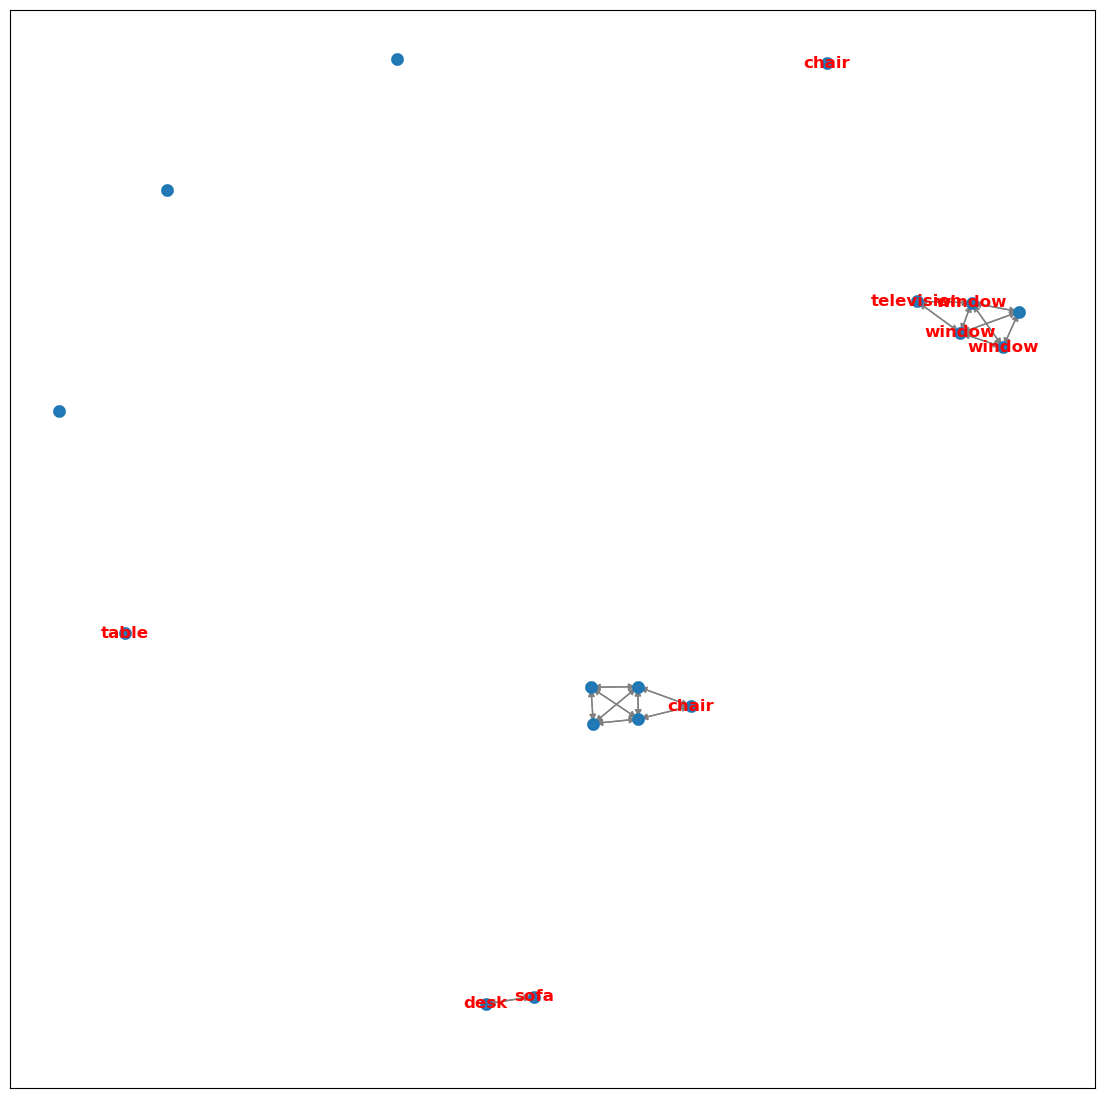


 
 
 
Graph label: Living room
Corresponding image:contrib\99991\downloads\ai_002_010\images\scene_cam_00_final_preview\frame.0089.tonemap.jpg


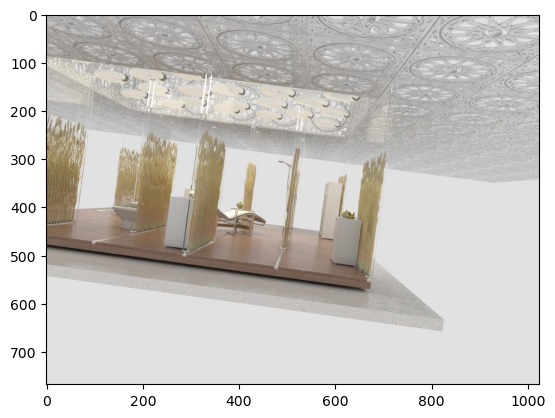

In [22]:
print('Possible graph labels:', dataset.scene_names[classes])

# select random graph in dataset
# i = random.randint(0, len(dataset))
i=2750
print(f'Current graph visualised: data_{i}.pt')

# construct labels for plotting
semantic_dict = {row[0]: row[1] for row in dataset.nyu_labels[1:]}
semantic_dict['-1'] = 'n/a'
print(semantic_dict)
custom_labels_dict = {j: semantic_dict[str(label.item())] for j, label in enumerate(dataset[i].x)}
nodes_to_remove = {'otherprop', 'otherfurniture', 'otherstructure'} # not plotting 'other' nodes
selected_labels_dict = {node: label for node, label in custom_labels_dict.items() if label not in nodes_to_remove}

# plot graph
vis = to_networkx(dataset[i])
plt.figure(1,figsize=(14,14))
pos = nx.spring_layout(vis, seed=42)
nx.draw_networkx(vis, node_size=10, linewidths=6, with_labels=True, labels=selected_labels_dict, font_weight='bold', font_color='red', edge_color='gray')
plt.show()

# plot corresponding image
file_path = 'processed/data_info.csv'
temp = pd.read_csv(file_path)
data = temp.to_numpy() # load image data
tonemap_dir = os.path.join("contrib\99991\downloads", data[i][1], "images", f"scene_{data[i][2]}_final_preview", f"frame.{data[i][3]:04d}.tonemap.jpg")

print('\n \n \n \nGraph label:', dataset.scene_names[classes][dataset[i].y])
print(f'Corresponding image:{tonemap_dir}')

tonemap = mpimg.imread(tonemap_dir)
im = plt.imshow(tonemap)


Create dataloader

In [39]:
train_loader = DataLoader(dataset, batch_size=int(config['datamodule']['batch_size']), shuffle=True, drop_last=False)

Setup GCN model (defined as in Pytorch Geometric tutorial: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=N-FO5xL3mw98)

In [54]:
model_name = config['model']['model_name']
model = globals()[model_name](feature_size=1, hidden_channels=int(config['model']['hidden_channels']))
print('Model:\n', model)
print('\nNo. parameters:', sum(p.numel() for p in model.parameters()))

optimizer_name = config['model']['optimizer']
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=float(config['model']['lr']))

criterion_name = config['model']['criterion']
criterion = getattr(nn, criterion_name)()

num_epochs = int(config['trainer']['epochs'])

Model:
 GCN(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=24, bias=True)
)

No. parameters: 984


Training